<a href="https://colab.research.google.com/github/HendricoYehezky/Tugas-3-Modern-Convolutional-Neural-Network/blob/main/Chapter_9_1_Gated_Recurrent_Units_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 462 kB 7.1 MB/s 


In [1]:
!pip install d2l

In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32)

    def three():
        return (tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32),
                tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32),
                tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    return params

In [4]:
def init_gru_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)), )

In [6]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        X = tf.reshape(X,[-1,W_xh.shape[0]])
        Z = tf.sigmoid(tf.matmul(X, W_xz) + tf.matmul(H, W_hz) + b_z)
        R = tf.sigmoid(tf.matmul(X, W_xr) + tf.matmul(H, W_hr) + b_r)
        H_tilda = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(R * H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,)

perplexity 1.1, 5371.1 tokens/sec on /CPU:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


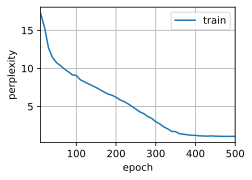

In [7]:
vocab_size, num_hiddens, device_name = len(vocab), 256, d2l.try_gpu()._device_name
# defining tensorflow training strategy
strategy = tf.distribute.OneDeviceStrategy(device_name)
num_epochs, lr = 500, 1
with strategy.scope():
    model = d2l.RNNModelScratch(len(vocab), num_hiddens, init_gru_state, gru, get_params)

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, strategy)

perplexity 1.0, 5796.5 tokens/sec on /CPU:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


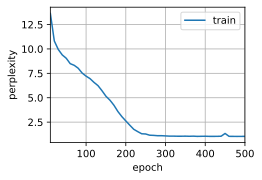

In [8]:
gru_cell = tf.keras.layers.GRUCell(num_hiddens,
    kernel_initializer='glorot_uniform')
gru_layer = tf.keras.layers.RNN(gru_cell, time_major=True,
    return_sequences=True, return_state=True)

device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    model = d2l.RNNModel(gru_layer, vocab_size=len(vocab))

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, strategy)